## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [106]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [107]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [108]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [109]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of        depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0          1     10.715021     678.292163  -152.775961      -4.194743   
1          2     10.715021     678.292163  -152.775961      -4.194743   
2          3     10.715021     678.292163  -152.775961      -4.194743   
3          4     10.715021     678.292163  -152.775961      -4.194743   
4          5     10.715021     678.292163  -152.775961      -4.194743   
...      ...           ...            ...          ...            ...   
35370     21     13.595026     718.547070  -230.901096     -40.903561   
35371     22     13.595026     718.547070  -230.901096     -40.903561   
35372     23     13.595026     718.547070  -230.901096     -40.903561   
35373     24     13.595026     718.547070  -230.901096     -40.903561   
35374     25     13.595026     718.547070  -230.901096     -40.903561   

       Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  ShearStress_Nm-2  \
0           

In [110]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [111]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [112]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat00']]

# Loading Models

In [113]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'input_temp']
m0_output_columns = ['temp_heat00']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [114]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00', 'diffusivity']
m1_output_columns = ['temp_diff01']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [115]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff01']
m2_output_columns = ['temp_mix02']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [116]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix02']
m3_output_columns = ['temp_conv03']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [117]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
m4_output_columns = ['temp_total04']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [118]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [119]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [120]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [121]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [122]:
print(train_data.shape)
print(test_data.shape)

(21225, 22)
(14150, 22)


In [123]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [124]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [125]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [126]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [127]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [128]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.040790718
RMSE of after m1 0.040761
RMSE of after m2 0.07363847
RMSE of after m3 0.07385284
RMSE of after m4 0.07402106
RMSE of after m0 0.02694151
RMSE of after m1 0.029091869
RMSE of after m2 0.065669484
RMSE of after m3 0.065538675
RMSE of after m4 0.06557597
RMSE of after m0 0.030935071
RMSE of after m1 0.030623265
RMSE of after m2 0.045838866
RMSE of after m3 0.04615947
RMSE of after m4 0.04623231
RMSE of after m0 0.027811687
RMSE of after m1 0.027523909
RMSE of after m2 0.03515069
RMSE of after m3 0.035276093
RMSE of after m4 0.03537795
RMSE of after m0 0.018092897
RMSE of after m1 0.018351134
RMSE of after m2 0.018110959
RMSE of after m3 0.01665239
RMSE of after m4 0.01724101
RMSE of after m0 0.026274059
RMSE of after m1 0.02563157
RMSE of after m2 0.026262654
RMSE of after m3 0.025824139
RMSE of after m4 0.02564594
RMSE of after m0 0.032673795
RMSE of after m1 0.031247094
RMSE of after m2 0.03183815
RMSE of after m3 0.0316044
RMSE of after m4 0.03153592
RMSE 

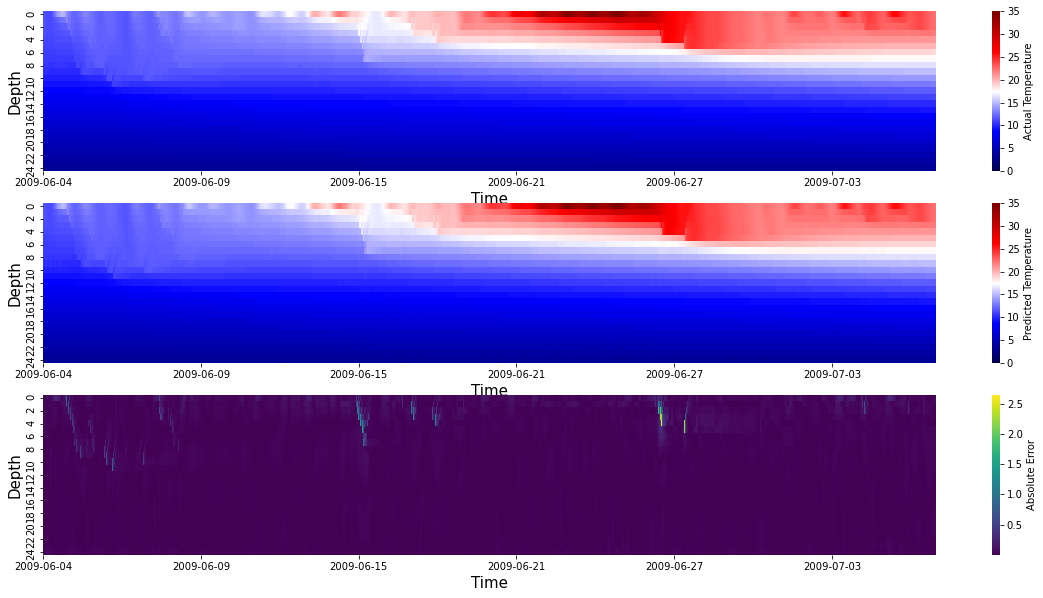

In [129]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

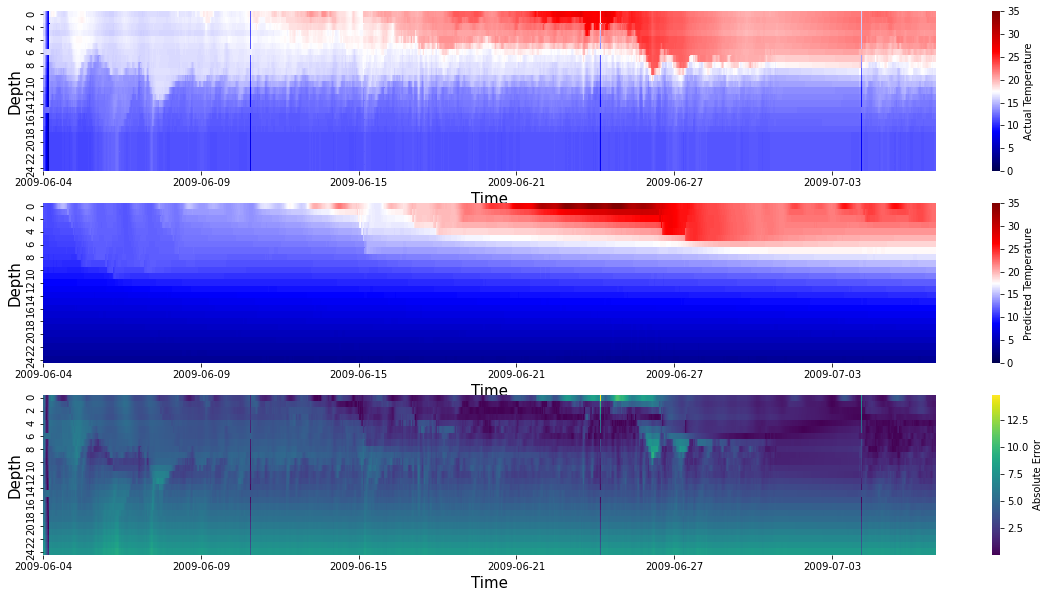

In [130]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [131]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.06562188
RMSE of after m1 0.06510015
RMSE of after m2 0.06932594
RMSE of after m3 0.069910586
RMSE of after m4 0.06895134
RMSE of after m0 0.10146639
RMSE of after m1 0.101814024
RMSE of after m2 0.09879452
RMSE of after m3 0.09714939
RMSE of after m4 0.09327093
RMSE of after m0 0.17078224
RMSE of after m1 0.17333515
RMSE of after m2 0.17235841
RMSE of after m3 0.1663088
RMSE of after m4 0.1649564
RMSE of after m0 0.26712635
RMSE of after m1 0.27073166
RMSE of after m2 0.3229043
RMSE of after m3 0.31725562
RMSE of after m4 0.3113361
RMSE of after m0 0.44920224
RMSE of after m1 0.4534322
RMSE of after m2 0.46536627
RMSE of after m3 0.44989172
RMSE of after m4 0.4435696
RMSE of after m0 0.681121
RMSE of after m1 0.6854215
RMSE of after m2 0.70595014
RMSE of after m3 0.6935847
RMSE of after m4 0.7121076
RMSE of after m0 0.7807158
RMSE of after m1 0.7812823
RMSE of after m2 0.817543
RMSE of after m3 0.8114149
RMSE of after m4 0.8392227
RMSE of after m0 0.7658944
RMSE of 

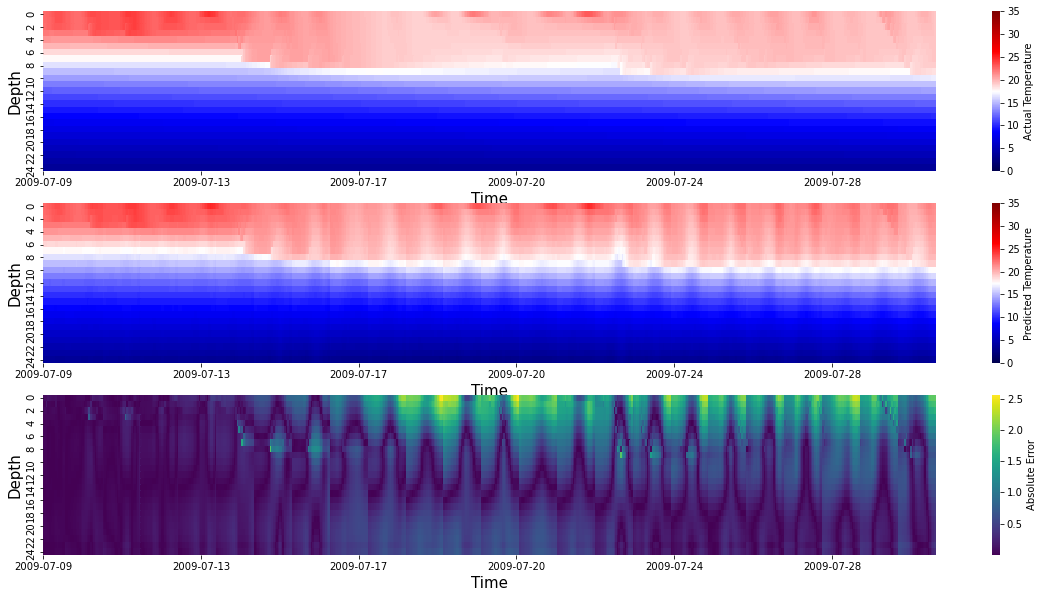

In [132]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

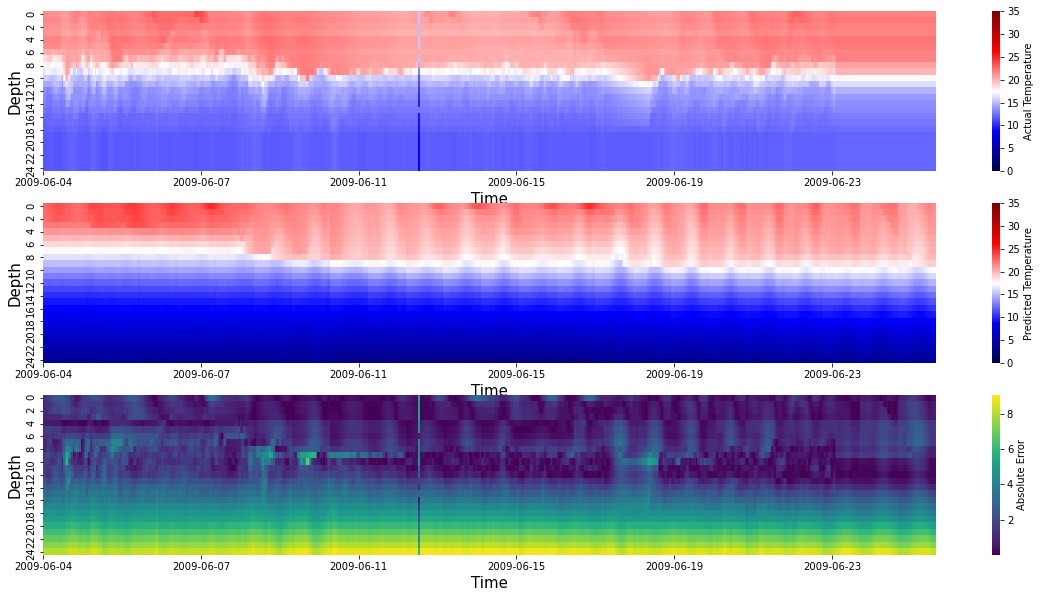

In [133]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [134]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 13.261519346474062, Train L2 Error: 1.0359958763316053
Test RMSE: 16.441904048999895, Train L2 Error: 1.1323659821278647


## Mixing Model

In [135]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06464672824655986, Train L2 Error: 0.005050188168577174
Test RMSE: 0.17823362266681597, Train L2 Error: 0.012274653288983025


## Convection Model

In [136]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.007789867537878315, Train L2 Error: 0.000608548609448087
Test RMSE: 0.0453234012849974, Train L2 Error: 0.0031213991515471797


## Ice Model

In [137]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.002282330588951952, Train L2 Error: 0.000178296883670224
Test RMSE: 0.12300266909677181, Train L2 Error: 0.00847113005801246


# Finetuning

In [138]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [139]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [140]:
freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)

# Finetuning on Observed Temperature

In [158]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
            
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
#         loss = loss_m4
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 2/5000 [00:00<15:44,  5.29it/s]

Epoch : 0, Train_loss: 0.5665123435583982, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0015755251303992488, Loss m2: 0.001545161749659614, Loss m3: 0.0014016967351463709, Loss m4: 0.5619661970572039


  1%|          | 52/5000 [00:09<15:12,  5.42it/s]

Epoch : 50, Train_loss: 0.5649497522549196, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0019723560332997954, Loss m2: 0.0019130697897212071, Loss m3: 0.0017344829181886532, Loss m4: 0.5593060729178515


  2%|▏         | 102/5000 [00:19<15:05,  5.41it/s]

Epoch : 100, Train_loss: 0.5633708279241215, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0024470418945632196, Loss m2: 0.0023555360226468606, Loss m3: 0.0021355626681311564, Loss m4: 0.5564089173620398


  3%|▎         | 152/5000 [00:28<14:52,  5.43it/s]

Epoch : 150, Train_loss: 0.5617904012853449, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0030167533656243572, Loss m2: 0.0028896935770965433, Loss m3: 0.0026208645748821173, Loss m4: 0.5532393252307718


  4%|▍         | 202/5000 [00:37<14:38,  5.46it/s]

Epoch : 200, Train_loss: 0.5602398230270906, Loss m0: 2.3768347814852447e-05, Loss m1: 0.003698303343050859, Loss m2: 0.0035326850748705592, Loss m3: 0.003206470631994307, Loss m4: 0.5497785996307026


  5%|▌         | 252/5000 [00:47<14:32,  5.44it/s]

Epoch : 250, Train_loss: 0.5587684065103531, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0045035256453874436, Loss m2: 0.004297265042127533, Loss m3: 0.003904620439491489, Loss m4: 0.5460392223163084


  6%|▌         | 302/5000 [00:56<15:02,  5.21it/s]

Epoch : 300, Train_loss: 0.5574407171119343, Loss m0: 2.3768347814852447e-05, Loss m1: 0.005429716950113123, Loss m2: 0.005182484588162465, Loss m3: 0.004715142178941856, Loss m4: 0.5420896031639793


  7%|▋         | 351/5000 [01:06<16:11,  4.79it/s]

Epoch : 350, Train_loss: 0.5563223849643361, Loss m0: 2.3768347814852447e-05, Loss m1: 0.006439737890931693, Loss m2: 0.00615401428446851, Loss m3: 0.00560722876848145, Loss m4: 0.5380976389754902


  8%|▊         | 401/5000 [01:15<14:08,  5.42it/s]

Epoch : 400, Train_loss: 0.5554434196515516, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0074300476011227475, Loss m2: 0.00711216570132158, Loss m3: 0.006489644335074859, Loss m4: 0.5343877944079313


  9%|▉         | 452/5000 [01:25<14:21,  5.28it/s]

Epoch : 450, Train_loss: 0.5547485514120623, Loss m0: 2.3768347814852447e-05, Loss m1: 0.00824033697559075, Loss m2: 0.007900007704103535, Loss m3: 0.007217644692652605, Loss m4: 0.5313667871735313


 10%|█         | 502/5000 [01:34<13:51,  5.41it/s]

Epoch : 500, Train_loss: 0.5541329790245403, Loss m0: 2.3768347814852447e-05, Loss m1: 0.008806910027157177, Loss m2: 0.008452961898662827, Loss m3: 0.007730788911100139, Loss m4: 0.5291185473853891


 11%|█         | 552/5000 [01:44<14:03,  5.28it/s]

Epoch : 550, Train_loss: 0.5535365708849647, Loss m0: 2.3768347814852447e-05, Loss m1: 0.009196097623895515, Loss m2: 0.008833838711408052, Loss m3: 0.008086232023990968, Loss m4: 0.5273966274478219


 12%|█▏        | 602/5000 [01:53<13:23,  5.47it/s]

Epoch : 600, Train_loss: 0.5529425388032739, Loss m0: 2.3768347814852447e-05, Loss m1: 0.009486933154138651, Loss m2: 0.009119009641422466, Loss m3: 0.00835409605960277, Loss m4: 0.5259587331251665


 13%|█▎        | 652/5000 [02:02<13:20,  5.43it/s]

Epoch : 650, Train_loss: 0.5523509207096967, Loss m0: 2.3768347814852447e-05, Loss m1: 0.009729291778057814, Loss m2: 0.00935692052272233, Loss m3: 0.008578901856460354, Loss m4: 0.5246620394966819


 14%|█▍        | 702/5000 [02:12<13:14,  5.41it/s]

Epoch : 700, Train_loss: 0.551765504208478, Loss m0: 2.3768347814852447e-05, Loss m1: 0.009945571210912683, Loss m2: 0.00956943766637282, Loss m3: 0.008780689211562276, Loss m4: 0.523446037010713


 15%|█▌        | 752/5000 [02:21<12:56,  5.47it/s]

Epoch : 750, Train_loss: 0.5511897192759947, Loss m0: 2.3768347814852447e-05, Loss m1: 0.010145365218208595, Loss m2: 0.009766007392582569, Loss m3: 0.00896807298572226, Loss m4: 0.5222865045070648


 16%|█▌        | 802/5000 [02:30<12:54,  5.42it/s]

Epoch : 800, Train_loss: 0.5506264106793837, Loss m0: 2.3768347814852447e-05, Loss m1: 0.010333239862864668, Loss m2: 0.00995117620649663, Loss m3: 0.00914517692713575, Loss m4: 0.521173051812432


 17%|█▋        | 852/5000 [02:40<12:35,  5.49it/s]

Epoch : 850, Train_loss: 0.5500779747962952, Loss m0: 2.3768347814852447e-05, Loss m1: 0.010511536320502108, Loss m2: 0.010127315255389973, Loss m3: 0.009314131076363, Loss m4: 0.5201012261889197


 18%|█▊        | 902/5000 [02:49<12:46,  5.35it/s]

Epoch : 900, Train_loss: 0.5495462309230458, Loss m0: 2.3768347814852447e-05, Loss m1: 0.010681315663863312, Loss m2: 0.010295525193214417, Loss m3: 0.009475897637788545, Loss m4: 0.5190697244622491


 19%|█▉        | 952/5000 [02:58<13:07,  5.14it/s]

Epoch : 950, Train_loss: 0.5490323521874168, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01084286275065758, Loss m2: 0.010456113356419584, Loss m3: 0.009630707960406487, Loss m4: 0.5180789001963355


 20%|██        | 1002/5000 [03:08<12:36,  5.29it/s]

Epoch : 1000, Train_loss: 0.5485367504033175, Loss m0: 2.3768347814852447e-05, Loss m1: 0.010995922652496532, Loss m2: 0.010608797596598213, Loss m3: 0.009778254982930694, Loss m4: 0.5171300050887194


 21%|██        | 1052/5000 [03:17<12:09,  5.41it/s]

Epoch : 1050, Train_loss: 0.5480593944137747, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011140340600501408, Loss m2: 0.010753338055854494, Loss m3: 0.009918274633078412, Loss m4: 0.516223667697473


 22%|██▏       | 1102/5000 [03:27<12:27,  5.21it/s]

Epoch : 1100, Train_loss: 0.5475996394049037, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011276178569956259, Loss m2: 0.010889670303599401, Loss m3: 0.01005066880448298, Loss m4: 0.5153593529354442


 23%|██▎       | 1152/5000 [03:37<11:46,  5.45it/s]

Epoch : 1150, Train_loss: 0.5471565411849455, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011403619904409756, Loss m2: 0.011017852335829626, Loss m3: 0.010175467108968984, Loss m4: 0.5145358361981132


 24%|██▍       | 1201/5000 [03:46<14:26,  4.38it/s]

Epoch : 1200, Train_loss: 0.5467288494110107, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011523113416677172, Loss m2: 0.011138221333650026, Loss m3: 0.010292973581024191, Loss m4: 0.5137507739392194


 25%|██▌       | 1252/5000 [03:57<12:15,  5.10it/s]

Epoch : 1250, Train_loss: 0.5463151633739471, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011635447894646362, Loss m2: 0.01125147815963084, Loss m3: 0.010403842601755803, Loss m4: 0.5130006264556538


 26%|██▌       | 1301/5000 [04:07<12:06,  5.09it/s]

Epoch : 1300, Train_loss: 0.5459141270680861, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011741479985754599, Loss m2: 0.011358417062596842, Loss m3: 0.010508827907456593, Loss m4: 0.5122816291722384


 27%|██▋       | 1352/5000 [04:17<11:50,  5.14it/s]

Epoch : 1350, Train_loss: 0.5455244020982222, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01184217542917891, Loss m2: 0.011459962549534712, Loss m3: 0.01060880995778875, Loss m4: 0.511589686978947


 28%|██▊       | 1402/5000 [04:27<11:27,  5.23it/s]

Epoch : 1400, Train_loss: 0.5451450239528309, Loss m0: 2.3768347814852447e-05, Loss m1: 0.011938586746427145, Loss m2: 0.011557143689556555, Loss m3: 0.010704771001738582, Loss m4: 0.510920757597143


 29%|██▉       | 1452/5000 [04:36<11:25,  5.18it/s]

Epoch : 1450, Train_loss: 0.5447751690040935, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012031736148690636, Loss m2: 0.011650975327938795, Loss m3: 0.01079767373051833, Loss m4: 0.5102710141377016


 30%|███       | 1502/5000 [04:46<11:24,  5.11it/s]

Epoch : 1500, Train_loss: 0.5444142412055623, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012122304475104267, Loss m2: 0.011742137668823654, Loss m3: 0.010888159402053465, Loss m4: 0.5096378705718301


 31%|███       | 1552/5000 [04:56<11:16,  5.10it/s]

Epoch : 1550, Train_loss: 0.5440617027607831, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01221065138551322, Loss m2: 0.011831001547927206, Loss m3: 0.010976567610420963, Loss m4: 0.5090197121555154


 32%|███▏      | 1602/5000 [05:06<11:30,  4.92it/s]

Epoch : 1600, Train_loss: 0.5437169792977247, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012297071347182447, Loss m2: 0.011917871169068596, Loss m3: 0.011063157813623548, Loss m4: 0.5084151137958873


 33%|███▎      | 1652/5000 [05:17<11:30,  4.85it/s]

Epoch : 1650, Train_loss: 0.5433795736594633, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012381507972763344, Loss m2: 0.012002702887085352, Loss m3: 0.01114785002375191, Loss m4: 0.5078237449580972


 34%|███▍      | 1701/5000 [05:26<11:34,  4.75it/s]

Epoch : 1700, Train_loss: 0.5430487353693355, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012463713318786838, Loss m2: 0.012085257479074326, Loss m3: 0.011230375384911895, Loss m4: 0.5072456218979575


 35%|███▌      | 1751/5000 [05:36<10:35,  5.12it/s]

Epoch : 1750, Train_loss: 0.5427235568111594, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012543265284462408, Loss m2: 0.012165112082253803, Loss m3: 0.011310297043316743, Loss m4: 0.506681115789847


 36%|███▌      | 1802/5000 [05:47<10:47,  4.94it/s]

Epoch : 1800, Train_loss: 0.5424029502001676, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012619954406876455, Loss m2: 0.012242045973173597, Loss m3: 0.011387377405877818, Loss m4: 0.506129808046601


 37%|███▋      | 1852/5000 [05:57<10:02,  5.23it/s]

Epoch : 1850, Train_loss: 0.5420857153155587, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012693401214412668, Loss m2: 0.012315662831745365, Loss m3: 0.011461225507611578, Loss m4: 0.5055916526100852


 38%|███▊      | 1902/5000 [06:06<09:43,  5.31it/s]

Epoch : 1900, Train_loss: 0.5417705503377047, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012763352471996437, Loss m2: 0.012385693167082289, Loss m3: 0.011531579837372357, Loss m4: 0.5050661536780271


 39%|███▉      | 1952/5000 [06:16<09:35,  5.29it/s]

Epoch : 1950, Train_loss: 0.5414560992609371, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012829700484871864, Loss m2: 0.012452012816952034, Loss m3: 0.011598322942683642, Loss m4: 0.5045522952621634


 40%|████      | 2002/5000 [06:26<09:40,  5.16it/s]

Epoch : 2000, Train_loss: 0.5411409816958688, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012892256998880343, Loss m2: 0.012514422266659412, Loss m3: 0.011661272347820077, Loss m4: 0.5040492605079304


 41%|████      | 2052/5000 [06:36<09:57,  4.94it/s]

Epoch : 2050, Train_loss: 0.5408238768577576, Loss m0: 2.3768347814852447e-05, Loss m1: 0.012951050165363333, Loss m2: 0.01257294285195795, Loss m3: 0.011720458236099645, Loss m4: 0.5035556581887332


 42%|████▏     | 2102/5000 [06:46<09:34,  5.05it/s]

Epoch : 2100, Train_loss: 0.5405035384676673, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013006082778288559, Loss m2: 0.012627576223828575, Loss m3: 0.011775891995057464, Loss m4: 0.5030702189965681


 43%|████▎     | 2152/5000 [06:55<09:00,  5.27it/s]

Epoch : 2150, Train_loss: 0.5401789220896634, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013057600579817186, Loss m2: 0.012678566092455929, Loss m3: 0.011827815874395046, Loss m4: 0.5025911751118574


 44%|████▍     | 2202/5000 [07:05<09:02,  5.16it/s]

Epoch : 2200, Train_loss: 0.5398492040959272, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013105857355350798, Loss m2: 0.012726170010864735, Loss m3: 0.011876482177864422, Loss m4: 0.5021169280463998


 45%|████▌     | 2252/5000 [07:15<08:53,  5.15it/s]

Epoch : 2250, Train_loss: 0.5395138263702393, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013151342430236664, Loss m2: 0.012770878108726307, Loss m3: 0.011922362747348168, Loss m4: 0.5016454742713408


 46%|████▌     | 2302/5000 [07:25<08:49,  5.10it/s]

Epoch : 2300, Train_loss: 0.5391724637963555, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013194428037174723, Loss m2: 0.012813065836036747, Loss m3: 0.011965818152847614, Loss m4: 0.5011753819205544


 47%|████▋     | 2352/5000 [07:34<08:35,  5.14it/s]

Epoch : 2350, Train_loss: 0.5388250676068392, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013235762038014152, Loss m2: 0.012853382112966343, Loss m3: 0.012007468104870482, Loss m4: 0.5007046921686693


 48%|████▊     | 2401/5000 [07:44<08:37,  5.02it/s]

Epoch : 2400, Train_loss: 0.5384718464179472, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013275789816609838, Loss m2: 0.01289227990094911, Loss m3: 0.012047745795412497, Loss m4: 0.5002322643995285


 49%|████▉     | 2452/5000 [07:54<08:08,  5.22it/s]

Epoch : 2450, Train_loss: 0.5381131741133603, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01331510233946822, Loss m2: 0.012930355204099958, Loss m3: 0.01208722379735925, Loss m4: 0.4997567263516513


 50%|█████     | 2502/5000 [08:04<08:02,  5.18it/s]

Epoch : 2500, Train_loss: 0.5377495776523243, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01335416632619771, Loss m2: 0.012968085367571224, Loss m3: 0.012126362205229023, Loss m4: 0.4992771961472251


 51%|█████     | 2552/5000 [08:14<07:49,  5.22it/s]

Epoch : 2550, Train_loss: 0.5373817181045358, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013393574690615589, Loss m2: 0.013006076343696226, Loss m3: 0.01216574595309794, Loss m4: 0.4987925494259054


 52%|█████▏    | 2601/5000 [08:27<15:40,  2.55it/s]

Epoch : 2600, Train_loss: 0.5370102294466712, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013433752835474232, Loss m2: 0.013044769621708176, Loss m3: 0.012205801396207376, Loss m4: 0.4983021359552037


 53%|█████▎    | 2651/5000 [08:37<09:50,  3.98it/s]

Epoch : 2650, Train_loss: 0.5366358337077227, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013475114902989431, Loss m2: 0.013084598562934181, Loss m3: 0.012246952709657226, Loss m4: 0.4978054003282027


 54%|█████▍    | 2702/5000 [08:48<07:35,  5.05it/s]

Epoch : 2700, Train_loss: 0.5362592122771523, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01351798926903443, Loss m2: 0.013125906105745922, Loss m3: 0.012289537180384452, Loss m4: 0.4973020147193562


 55%|█████▌    | 2752/5000 [08:58<07:14,  5.17it/s]

Epoch : 2750, Train_loss: 0.535880986939777, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013562642799859697, Loss m2: 0.013168975245207548, Loss m3: 0.012333836469968612, Loss m4: 0.4967917664484544


 56%|█████▌    | 2802/5000 [09:08<07:43,  4.75it/s]

Epoch : 2800, Train_loss: 0.5355017754164609, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013609327545220202, Loss m2: 0.01321406780996106, Loss m3: 0.01238010872409425, Loss m4: 0.49627450514923444


 57%|█████▋    | 2852/5000 [09:17<06:48,  5.25it/s]

Epoch : 2850, Train_loss: 0.5351220816373825, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013658188622106205, Loss m2: 0.013261332642287016, Loss m3: 0.012428503674031659, Loss m4: 0.49575028907168994


 58%|█████▊    | 2902/5000 [09:27<06:43,  5.20it/s]

Epoch : 2900, Train_loss: 0.5347423594106328, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013709209055047144, Loss m2: 0.013310755518349733, Loss m3: 0.012479016091674566, Loss m4: 0.49521961266344244


 59%|█████▉    | 2952/5000 [09:37<06:45,  5.05it/s]

Epoch : 2950, Train_loss: 0.5343630164861679, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013762460259551352, Loss m2: 0.013362405567683956, Loss m3: 0.012531714069403031, Loss m4: 0.4946826696395874


 60%|██████    | 3002/5000 [09:47<06:37,  5.03it/s]

Epoch : 3000, Train_loss: 0.5339843576604669, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013817789244719526, Loss m2: 0.013416125396774574, Loss m3: 0.01258645073341375, Loss m4: 0.49414022944190283


 61%|██████    | 3052/5000 [09:57<06:27,  5.03it/s]

Epoch : 3050, Train_loss: 0.5336066362532702, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013875337275253101, Loss m2: 0.013472049031406641, Loss m3: 0.012643350436436858, Loss m4: 0.4935921308669177


 62%|██████▏   | 3102/5000 [10:06<06:05,  5.20it/s]

Epoch : 3100, Train_loss: 0.5332300364971161, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013934851581738754, Loss m2: 0.013529912356964567, Loss m3: 0.012702164854007688, Loss m4: 0.4930393411354585


 63%|██████▎   | 3152/5000 [10:16<06:03,  5.08it/s]

Epoch : 3150, Train_loss: 0.5328547615896572, Loss m0: 2.3768347814852447e-05, Loss m1: 0.013996441552246159, Loss m2: 0.013589817988262936, Loss m3: 0.012762983075597069, Loss m4: 0.49248175593939697


 64%|██████▍   | 3202/5000 [10:26<05:47,  5.17it/s]

Epoch : 3200, Train_loss: 0.5324810269204053, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014060085893354633, Loss m2: 0.013651727063750679, Loss m3: 0.012825761667706749, Loss m4: 0.49191968684846704


 65%|██████▌   | 3251/5000 [10:36<05:36,  5.20it/s]

Epoch : 3250, Train_loss: 0.5321089909835295, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014126031405546448, Loss m2: 0.013715870636091991, Loss m3: 0.012890704949809746, Loss m4: 0.49135261367667804


 66%|██████▌   | 3302/5000 [10:46<05:25,  5.22it/s]

Epoch : 3300, Train_loss: 0.5317390425638719, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01419454055245627, Loss m2: 0.013782497156750072, Loss m3: 0.012958027083765377, Loss m4: 0.4907802113077857


 67%|██████▋   | 3352/5000 [10:56<05:24,  5.08it/s]

Epoch : 3350, Train_loss: 0.5313715758648786, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014265729453076016, Loss m2: 0.0138517211784016, Loss m3: 0.013027815317565744, Loss m4: 0.4902025420557369


 68%|██████▊   | 3401/5000 [11:05<05:09,  5.17it/s]

Epoch : 3400, Train_loss: 0.5310070568864996, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014339652251113544, Loss m2: 0.013923605480654673, Loss m3: 0.013100113677368923, Loss m4: 0.48961991749026557


 69%|██████▉   | 3452/5000 [11:15<04:58,  5.19it/s]

Epoch : 3450, Train_loss: 0.5306457850066099, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014415993566878817, Loss m2: 0.013997855638577179, Loss m3: 0.013174634977159176, Loss m4: 0.48903352834961633


 70%|███████   | 3501/5000 [11:25<05:47,  4.31it/s]

Epoch : 3500, Train_loss: 0.5302880826321515, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01449425569312139, Loss m2: 0.014073998413302681, Loss m3: 0.01325093586505814, Loss m4: 0.4884451248429038


 71%|███████   | 3551/5000 [11:37<05:20,  4.52it/s]

Epoch : 3550, Train_loss: 0.5299340202049776, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014573959972370754, Loss m2: 0.01415157580578869, Loss m3: 0.01332858827134425, Loss m4: 0.48785612799904565


 72%|███████▏  | 3601/5000 [11:47<04:38,  5.02it/s]

Epoch : 3600, Train_loss: 0.5295835746960207, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014654586599631743, Loss m2: 0.014230071101337671, Loss m3: 0.01340711514719508, Loss m4: 0.48726803199811414


 73%|███████▎  | 3651/5000 [11:57<04:50,  4.65it/s]

Epoch : 3650, Train_loss: 0.5292366390878503, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014735636386004362, Loss m2: 0.014308985280381008, Loss m3: 0.013486052566969936, Loss m4: 0.486682191491127


 74%|███████▍  | 3701/5000 [12:08<04:50,  4.47it/s]

Epoch : 3700, Train_loss: 0.5288930318572305, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014816850720142776, Loss m2: 0.014388040935789997, Loss m3: 0.013565139421685175, Loss m4: 0.48609923368150537


 75%|███████▌  | 3752/5000 [12:19<04:11,  4.96it/s]

Epoch : 3750, Train_loss: 0.528552692044865, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014898129357871685, Loss m2: 0.014467124361544847, Loss m3: 0.013644263698634777, Loss m4: 0.48551940511573444


 76%|███████▌  | 3801/5000 [12:28<04:01,  4.96it/s]

Epoch : 3800, Train_loss: 0.5282154394821688, Loss m0: 2.3768347814852447e-05, Loss m1: 0.014979530295187777, Loss m2: 0.014546280938454649, Loss m3: 0.013723466376012022, Loss m4: 0.48494239286942914


 77%|███████▋  | 3851/5000 [12:39<04:23,  4.36it/s]

Epoch : 3850, Train_loss: 0.5278812172737989, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015061224387450651, Loss m2: 0.014625672674314543, Loss m3: 0.013802892274477264, Loss m4: 0.48436766185543756


 78%|███████▊  | 3901/5000 [12:49<03:34,  5.13it/s]

Epoch : 3900, Train_loss: 0.527549918402325, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015143272932618856, Loss m2: 0.014705362941392443, Loss m3: 0.01388259922069582, Loss m4: 0.4837949140505357


 79%|███████▉  | 3951/5000 [13:00<03:27,  5.05it/s]

Epoch : 3950, Train_loss: 0.5272214995189146, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015225795605643229, Loss m2: 0.014785465657372366, Loss m3: 0.013962690337476406, Loss m4: 0.48322377692569385


 80%|████████  | 4001/5000 [13:10<03:17,  5.06it/s]

Epoch : 4000, Train_loss: 0.5268959254026413, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015308842867274176, Loss m2: 0.014866032171994448, Loss m3: 0.014043208592655983, Loss m4: 0.48265407573093067


 81%|████████  | 4052/5000 [13:21<03:07,  5.06it/s]

Epoch : 4050, Train_loss: 0.5265731743790887, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015392295973883434, Loss m2: 0.014946943318301981, Loss m3: 0.014124036766588688, Loss m4: 0.4820861288092353


 82%|████████▏ | 4101/5000 [13:31<02:59,  5.02it/s]

Epoch : 4100, Train_loss: 0.5262532098726793, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015476293650201776, Loss m2: 0.01502833536572077, Loss m3: 0.014205302704464306, Loss m4: 0.48151951080018823


 83%|████████▎ | 4151/5000 [13:41<02:46,  5.10it/s]

Epoch : 4150, Train_loss: 0.5259359655055132, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015560794113711878, Loss m2: 0.015110165219415318, Loss m3: 0.014286963015117428, Loss m4: 0.48095427318052814


 84%|████████▍ | 4202/5000 [13:51<02:40,  4.97it/s]

Epoch : 4200, Train_loss: 0.5256214873357252, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015645597426390104, Loss m2: 0.01519223391501741, Loss m3: 0.014368827793408524, Loss m4: 0.48039106076413934


 85%|████████▌ | 4252/5000 [14:01<02:31,  4.92it/s]

Epoch : 4250, Train_loss: 0.5253096669912338, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015730802816423504, Loss m2: 0.015274645760655403, Loss m3: 0.014450993007895622, Loss m4: 0.47982946038246155


 86%|████████▌ | 4302/5000 [14:11<02:16,  5.13it/s]

Epoch : 4300, Train_loss: 0.5250005193732001, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015816187189722605, Loss m2: 0.015357189600101927, Loss m3: 0.014533261345191435, Loss m4: 0.4792701154947281


 87%|████████▋ | 4352/5000 [14:21<02:05,  5.17it/s]

Epoch : 4350, Train_loss: 0.5246938737955961, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015901949679986996, Loss m2: 0.015440066133371809, Loss m3: 0.014615826308727264, Loss m4: 0.478712260723114


 88%|████████▊ | 4402/5000 [14:31<01:57,  5.10it/s]

Epoch : 4400, Train_loss: 0.524389689618891, Loss m0: 2.3768347814852447e-05, Loss m1: 0.015987787226384335, Loss m2: 0.015522988513112068, Loss m3: 0.014698416333306919, Loss m4: 0.47815673324194824


 89%|████████▉ | 4452/5000 [14:41<01:46,  5.16it/s]

Epoch : 4450, Train_loss: 0.5240879519419237, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016073707279495218, Loss m2: 0.01560595982962034, Loss m3: 0.014781029767949472, Loss m4: 0.47760348699309607


 90%|█████████ | 4501/5000 [14:50<01:37,  5.10it/s]

Epoch : 4500, Train_loss: 0.5237885415554047, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016159783794798634, Loss m2: 0.015689063563265583, Loss m3: 0.014863747299056162, Loss m4: 0.47705217924985016


 91%|█████████ | 4551/5000 [15:00<01:28,  5.07it/s]

Epoch : 4550, Train_loss: 0.5234913988546892, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016246084885841065, Loss m2: 0.01577236308631572, Loss m3: 0.014946627176620743, Loss m4: 0.47650255398316815


 92%|█████████▏| 4601/5000 [15:10<01:21,  4.90it/s]

Epoch : 4600, Train_loss: 0.5231964791362936, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016332561361857435, Loss m2: 0.015855813441290098, Loss m3: 0.015029625205153769, Loss m4: 0.4759547087279233


 93%|█████████▎| 4652/5000 [15:20<01:06,  5.20it/s]

Epoch : 4650, Train_loss: 0.5229037959467281, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016419205475937237, Loss m2: 0.015939411241561174, Loss m3: 0.015112734145738861, Loss m4: 0.47540867599574005


 94%|█████████▍| 4702/5000 [15:30<00:58,  5.07it/s]

Epoch : 4700, Train_loss: 0.5226132368499582, Loss m0: 2.3768347814852447e-05, Loss m1: 0.01650618567046794, Loss m2: 0.016023323701863938, Loss m3: 0.015196111476556822, Loss m4: 0.4748638489029624


 95%|█████████▌| 4752/5000 [15:40<00:48,  5.16it/s]

Epoch : 4750, Train_loss: 0.5223247815262188, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016593545124950735, Loss m2: 0.016107604246247898, Loss m3: 0.01527980791235512, Loss m4: 0.47432005540891126


 96%|█████████▌| 4802/5000 [15:50<00:39,  5.03it/s]

Epoch : 4800, Train_loss: 0.5220384814522483, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016681094526905905, Loss m2: 0.016192066779529505, Loss m3: 0.015363642734221437, Loss m4: 0.47377791052514856


 97%|█████████▋| 4852/5000 [16:00<00:28,  5.19it/s]

Epoch : 4850, Train_loss: 0.521754266186194, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016769094731320034, Loss m2: 0.01627697448500178, Loss m3: 0.015447866510261189, Loss m4: 0.47323656488548627


 98%|█████████▊| 4902/5000 [16:10<00:19,  5.10it/s]

Epoch : 4900, Train_loss: 0.5214721154082905, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016857613386078316, Loss m2: 0.016362403604117306, Loss m3: 0.01553254680369388, Loss m4: 0.47269578819925134


 99%|█████████▉| 4952/5000 [16:20<00:09,  5.12it/s]

Epoch : 4950, Train_loss: 0.5211921280080621, Loss m0: 2.3768347814852447e-05, Loss m1: 0.016946287868036466, Loss m2: 0.016448006584224375, Loss m3: 0.01561736036092043, Loss m4: 0.47215670347213745


100%|██████████| 5000/5000 [16:30<00:00,  5.05it/s]


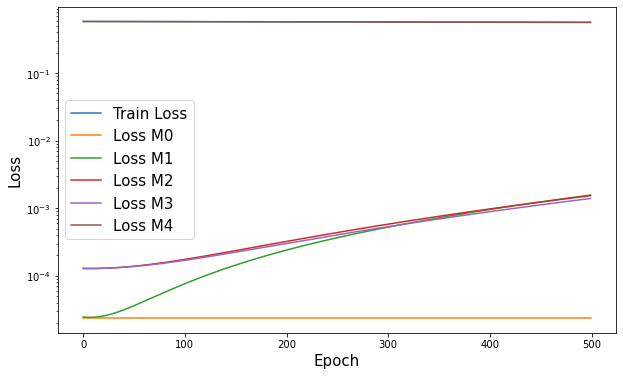

In [142]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [143]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.040790718
RMSE of after m1 0.22017734
RMSE of after m2 0.22651881
RMSE of after m3 0.2194689
RMSE of after m4 0.21441609
RMSE of after m0 0.02694151
RMSE of after m1 0.22057265
RMSE of after m2 0.22106948
RMSE of after m3 0.21386589
RMSE of after m4 0.20843385
RMSE of after m0 0.030935071
RMSE of after m1 0.22201857
RMSE of after m2 0.2193771
RMSE of after m3 0.21225025
RMSE of after m4 0.20530781
RMSE of after m0 0.027811687
RMSE of after m1 0.2228671
RMSE of after m2 0.22450058
RMSE of after m3 0.21609467
RMSE of after m4 0.20986769
RMSE of after m0 0.018092897
RMSE of after m1 0.22271636
RMSE of after m2 0.22182173
RMSE of after m3 0.21303034
RMSE of after m4 0.2062074
RMSE of after m0 0.026274059
RMSE of after m1 0.22611955
RMSE of after m2 0.2237996
RMSE of after m3 0.21521202
RMSE of after m4 0.20745367
RMSE of after m0 0.032673795
RMSE of after m1 0.22908086
RMSE of after m2 0.22765264
RMSE of after m3 0.21782108
RMSE of after m4 0.21110128
RMSE of after m0 0.

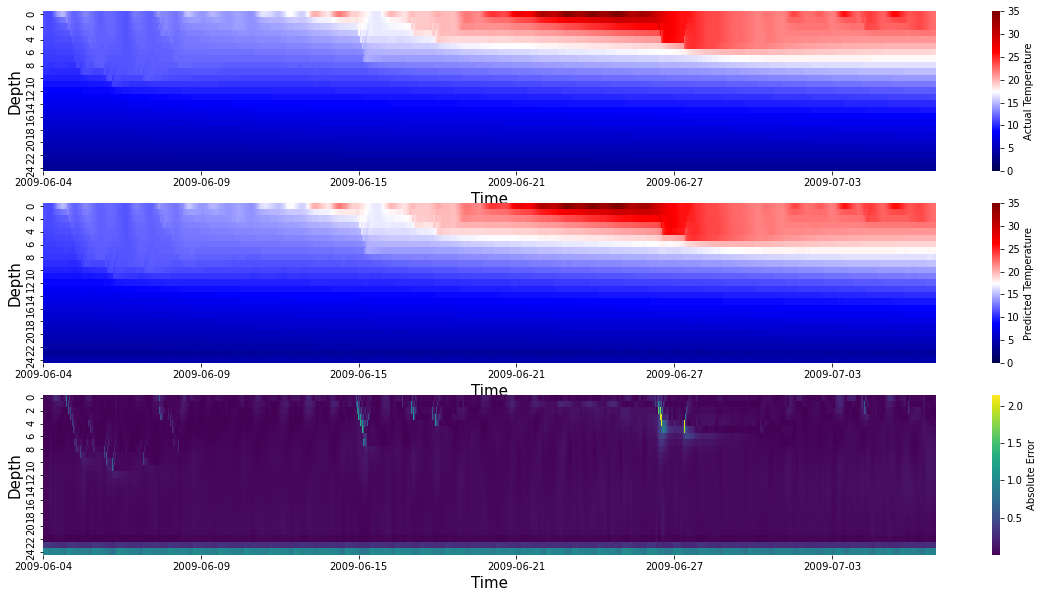

In [144]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

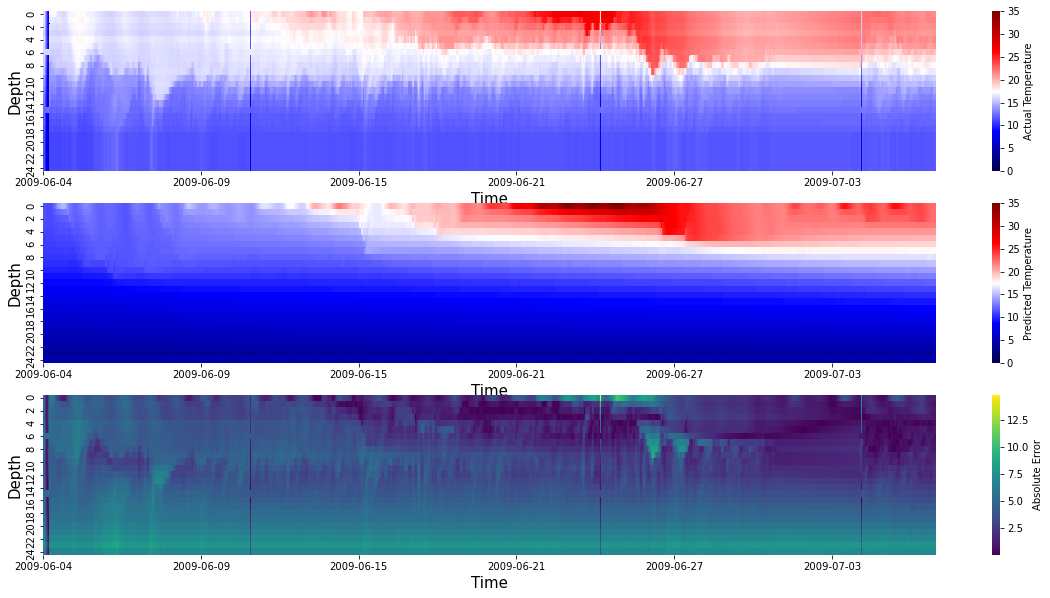

In [145]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [146]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.06562188
RMSE of after m1 0.2432305
RMSE of after m2 0.22796421
RMSE of after m3 0.21329045
RMSE of after m4 0.20456329
RMSE of after m0 0.10146639
RMSE of after m1 0.2608934
RMSE of after m2 0.24602282
RMSE of after m3 0.230024
RMSE of after m4 0.22129403
RMSE of after m0 0.17078224
RMSE of after m1 0.26328775
RMSE of after m2 0.25993016
RMSE of after m3 0.24625462
RMSE of after m4 0.24360006
RMSE of after m0 0.26712635
RMSE of after m1 0.31567326
RMSE of after m2 0.3518255
RMSE of after m3 0.34164786
RMSE of after m4 0.33776855
RMSE of after m0 0.44920224
RMSE of after m1 0.45191854
RMSE of after m2 0.46751317
RMSE of after m3 0.451342
RMSE of after m4 0.44889784
RMSE of after m0 0.681121
RMSE of after m1 0.6649982
RMSE of after m2 0.69656724
RMSE of after m3 0.68693745
RMSE of after m4 0.7105941
RMSE of after m0 0.7807158
RMSE of after m1 0.76607406
RMSE of after m2 0.81635755
RMSE of after m3 0.8135649
RMSE of after m4 0.847152
RMSE of after m0 0.7658944
RMSE of 

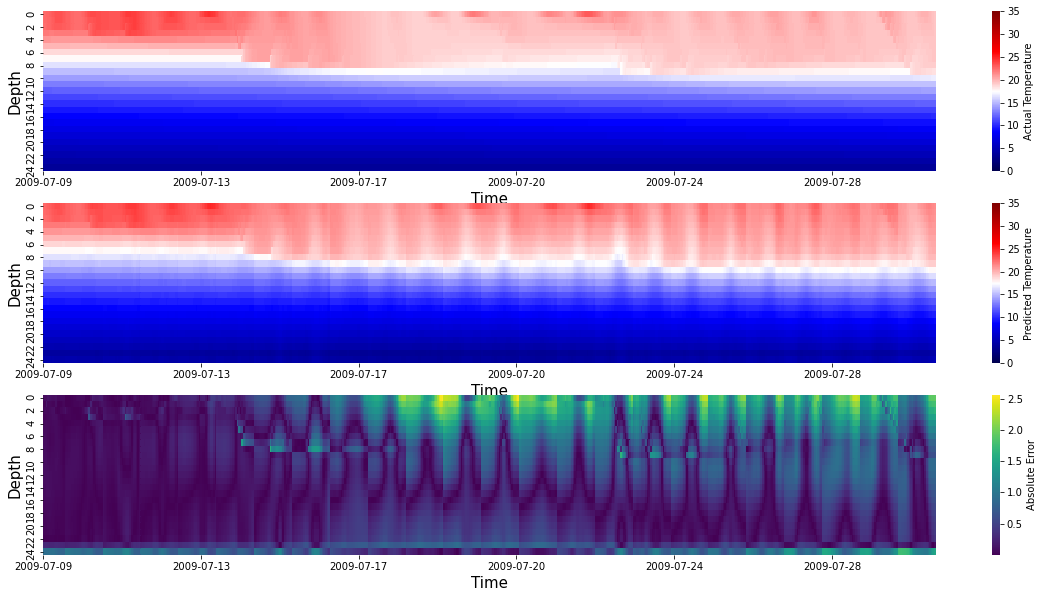

In [147]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

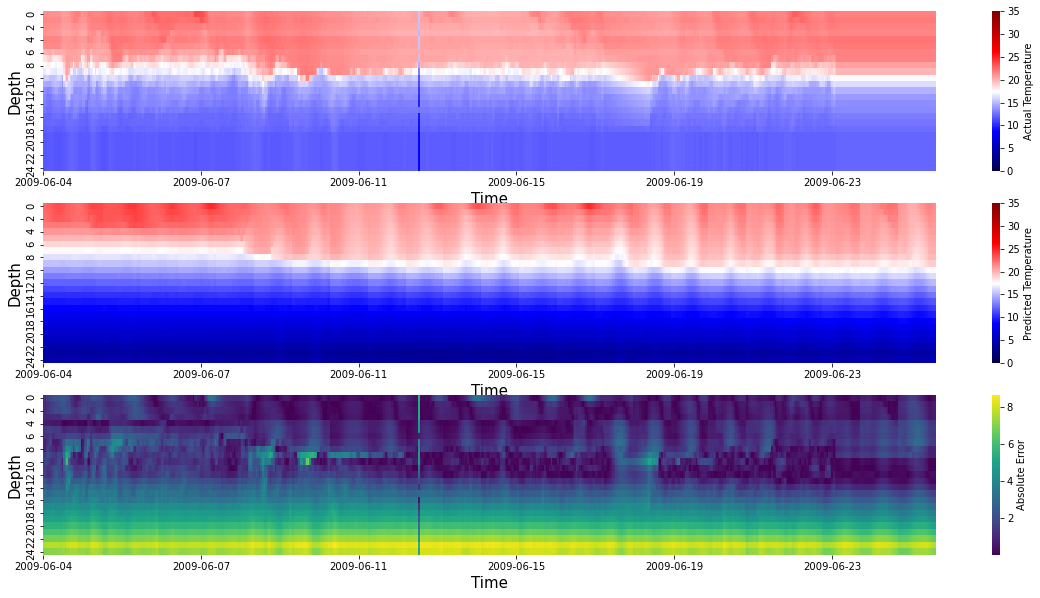

In [148]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [149]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 15.117734266139427, Train L2 Error: 1.1810042235742468
Test RMSE: 23.357537718829807, Train L2 Error: 1.6086507414377096


## Mixing Model

In [150]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06464672824655986, Train L2 Error: 0.005050188168577174
Test RMSE: 0.17823362266681597, Train L2 Error: 0.012274653288983025


## Convection Model

In [151]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.007789867537878315, Train L2 Error: 0.000608548609448087
Test RMSE: 0.0453234012849974, Train L2 Error: 0.0031213991515471797


## Ice Model

In [152]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.002282330588951952, Train L2 Error: 0.000178296883670224
Test RMSE: 0.12300266909677181, Train L2 Error: 0.00847113005801246


# Compute Model Similarity after Finetuning

In [153]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [154]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.961081326007843
L2 Norm: 2.38468599319458


In [155]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [156]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [157]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0
